In [1]:
%matplotlib inline

import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        # starting state of the 
        state = env.reset()
        

        for t in itertools.count():
            # agent acts epislon greedily:
            action__dist = policy(state) 
            action = np.random.choice(np.arange(len(action__dist)), p = action__dist)
            
            # environment responds, give (next_state, rewards, done, {'prob': p})
            # the choice of next_state is random, determined according to transition probability:
            next_state, reward, done, _ = env.step(action)

            # agent do not need to act yet

            # best return over next state given Q:
            #print('Q[next_state] is', Q[next_state])
            best_action_value_on_next = np.max( Q[next_state])


            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # update Q, according to max of all actions over next state:
            Q[state][action] += alpha*( reward + discount_factor*best_action_value_on_next - Q[state][action])
            state = next_state




            if done:
                break
            


        
    
    return Q, stats

In [22]:
Q_with_q_learning, stats = q_learning(env, 500)

Episode 500/500.

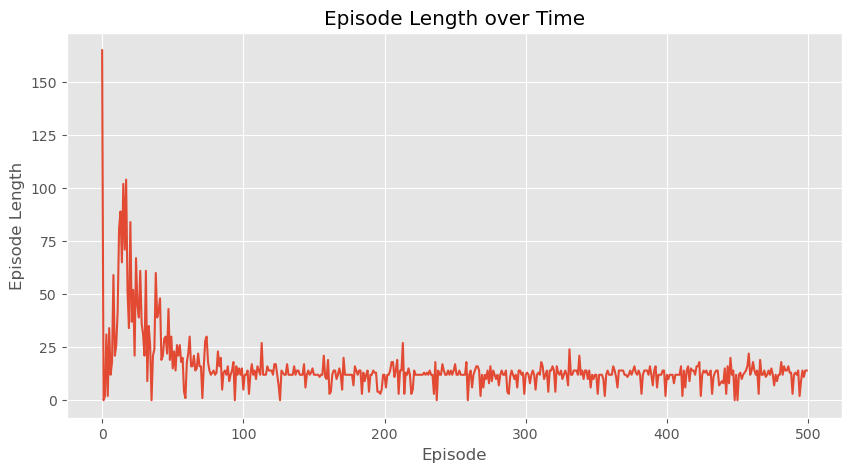

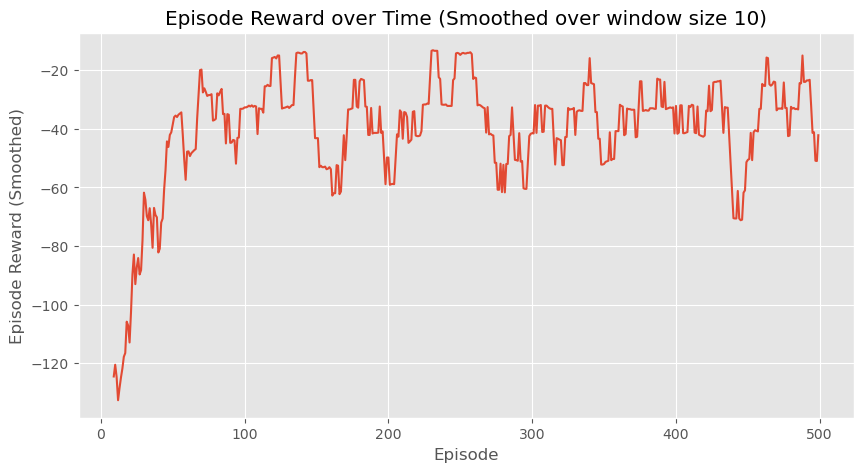

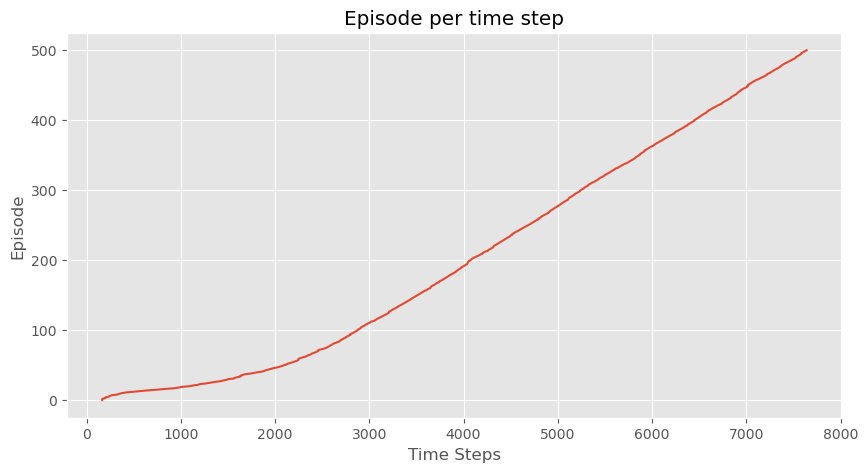

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [23]:
plotting.plot_episode_stats(stats)

# comparison with SARSA:



In [24]:
from IPython.display import clear_output
import time

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}. Number of steps to end episode is {}:".format(i_episode + 1, num_episodes, num_of_steps_to_end_epi), end="")
            # time.sleep(0.1)


            sys.stdout.flush()
        
        # Implement this!
        # reset the env:
        
        state = env.reset() # reset will return just the state, as int
        # choose initial action:
        action_distribution = policy(state)
        action = np.random.choice(np.arange(len(action_distribution)), p = action_distribution)
        
        num_of_steps_to_end_epi =0 

        while True: # keep going while the done is False

            # keep track of num of steps:
            num_of_steps_to_end_epi += 1
            # the env's response to action:
            # in the form of (state, reward, done, prob_of_state)
            next_state, reward, done, _ = env.step(action)

            # keep going using epilson greedy policy on Q, on next_state:
            next_action_dist = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_dist)), p = next_action_dist)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = num_of_steps_to_end_epi

            # render the result
            # env.render()
            # clear_output(wait= True)

            # update the value of current state by bootstrapping from the estimation of the next state:
            Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
 

            if done:
                
                break
                
    return Q, stats

In [25]:
env2 = CliffWalkingEnv()

Episode 500/500. Number of steps to end episode is 19:

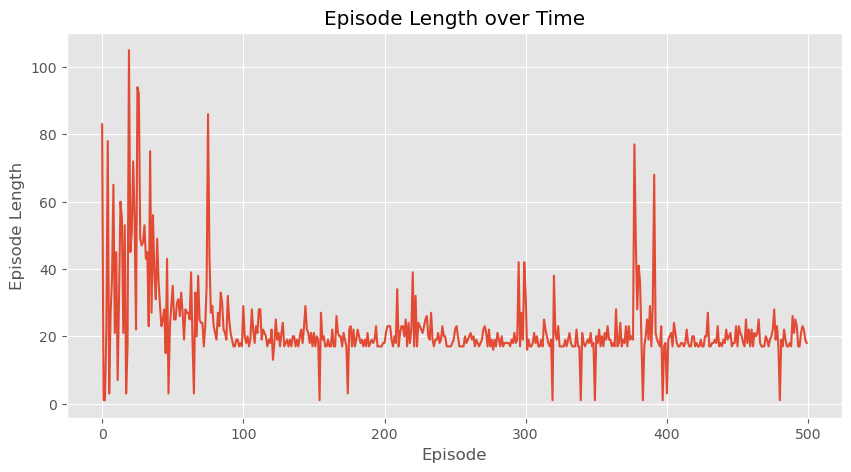

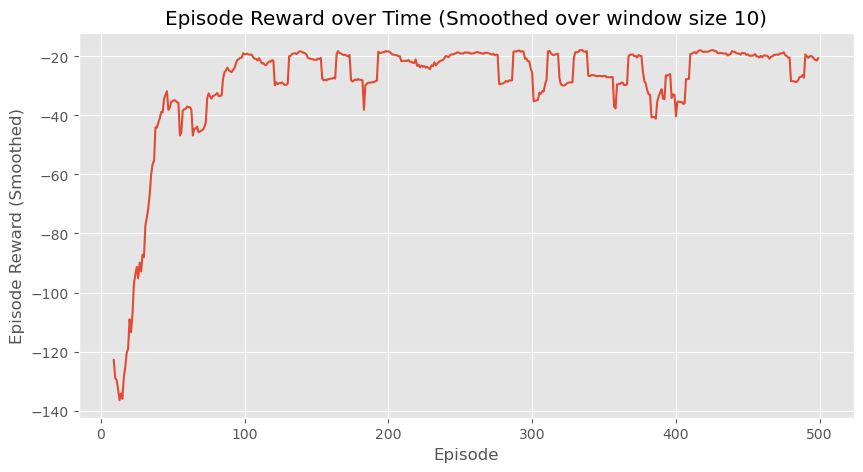

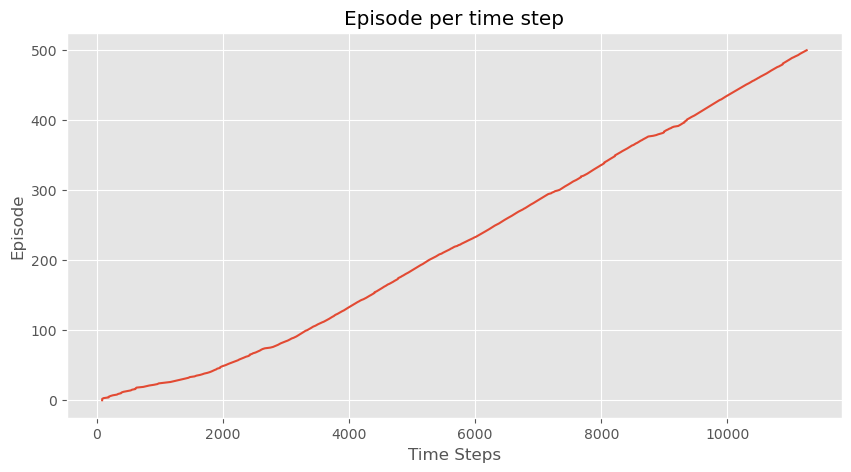

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [27]:
Q_with_sarsa, stats2 = sarsa(env2, 500)
plotting.plot_episode_stats(stats2)


## comparison of online performance:


In [28]:
from lib import plotting
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


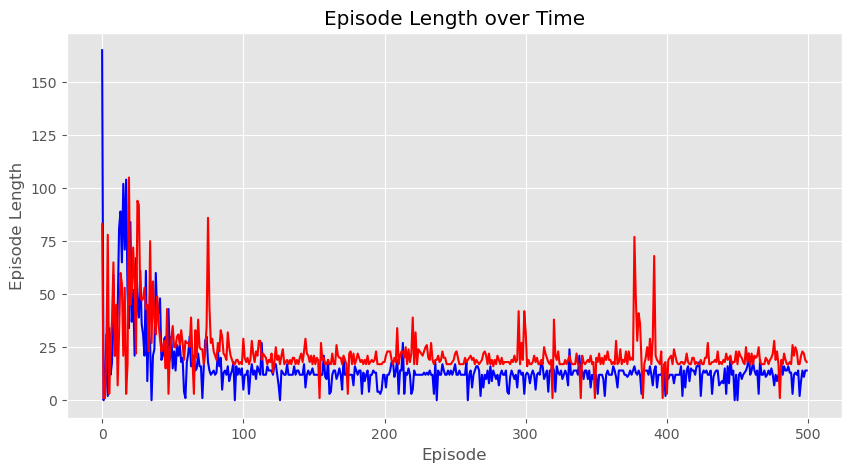

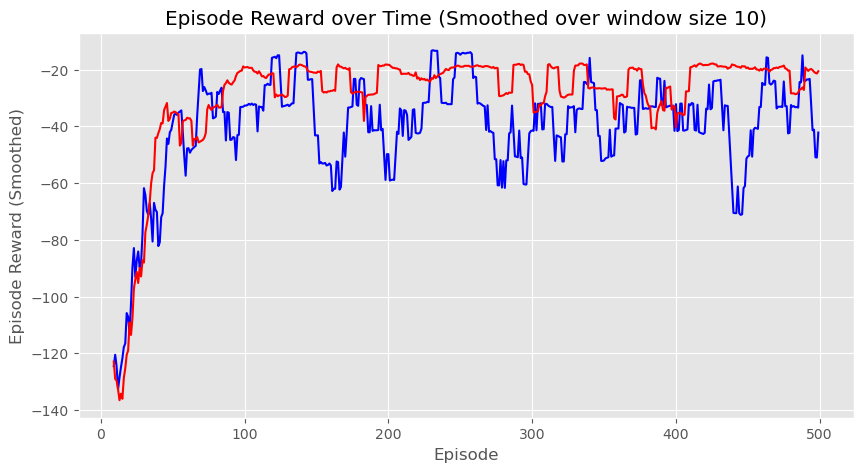

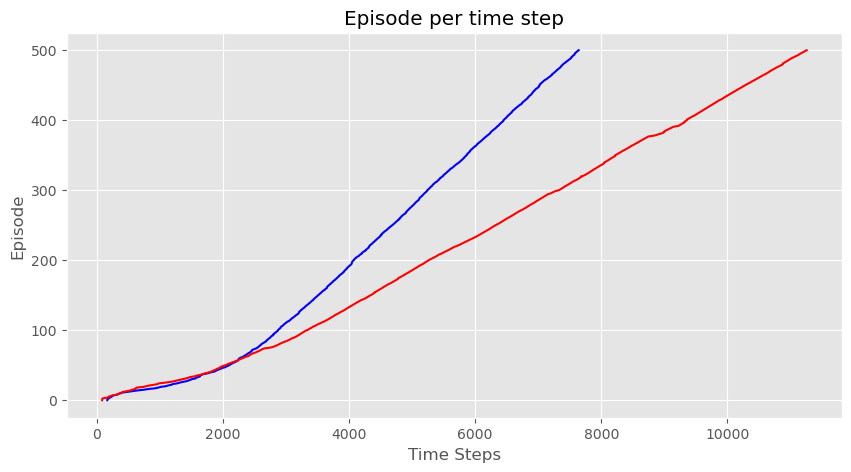

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [30]:
# blue is stats (Q-learning)
# red is stats 2 (SARSA)

plotting.plot_episode_two_stats(stats, stats2)

## comparison of offline learning 

In [32]:
state

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



In [ ]:
    state = env.reset() # reset will return just the state, as int
    # choose initial action:
    action_distribution = policy(state)
    action = np.random.choice(np.arange(len(action_distribution)), p = action_distribution)
    
    num_of_steps_to_end_epi =0 

    while True: # keep going while the done is False

        # keep track of num of steps:
        num_of_steps_to_end_epi += 1
        # the env's response to action:
        # in the form of (state, reward, done, prob_of_state)
        next_state, reward, done, _ = env.step(action)

        # keep going using epilson greedy policy on Q, on next_state:
        next_action_dist = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_action_dist)), p = next_action_dist)

        # Update statistics
        stats.episode_rewards[i_episode] += reward
        stats.episode_lengths[i_episode] = num_of_steps_to_end_epi

        # render the result
        # env.render()
        # clear_output(wait= True)

        # update the value of current state by bootstrapping from the estimation of the next state:
        Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_action] - Q[state][action])
        state = next_state
        action = next_action


        if done:
            
            break